In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

device = torch.device('mps')

In [2]:
train = pd.read_csv('digit-recognizer/train.csv')
test = pd.read_csv('digit-recognizer/test.csv')

print('train:', train.shape)
print('test:', test.shape)

train: (42000, 785)
test: (28000, 784)


In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
class TrainDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.labels = dataframe.iloc[:, 0].values
        self.features = dataframe.iloc[:, 1:].values
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature = self.features[idx].reshape(28, 28).astype(np.uint8)
        label = self.labels[idx]
        if self.transform:
            feature = self.transform(feature)
        return feature, label

class TestDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.features = dataframe.values
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx].reshape(28, 28).astype(np.uint8)
        if self.transform:
            feature = self.transform(feature)
        return feature

train_mean = train.drop('label', axis=1).values.mean()/255
train_std = train.drop('label', axis=1).values.std()/255

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(5),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.25),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

In [6]:
training_set = TrainDataset(train, transform=train_transform)
testing_set = TestDataset(test, transform=test_transform)

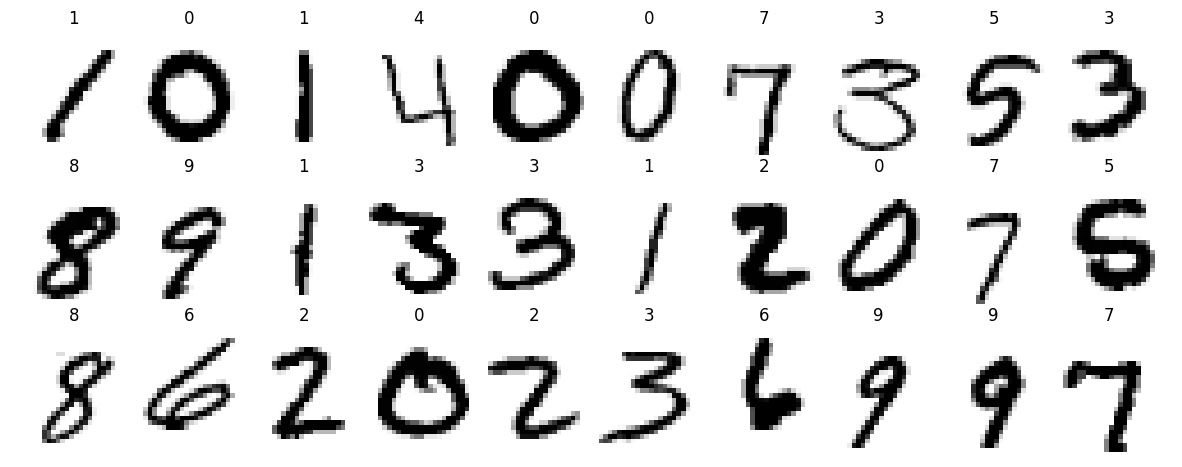

In [7]:
plt.figure(figsize=(15, 6))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(training_set.features[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.title(training_set.labels[i])
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128, 10),
        )   
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [9]:
def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [10]:
n_splits = 5
batch_size = 100
learning_rate = 0.0001
epochs = 100
loss_fn = nn.CrossEntropyLoss()
training_losses_list, validation_losses_list, validation_accuracies_list = [], [], []

In [11]:
kf = KFold(n_splits=n_splits, shuffle=True)

for fold, (training_ids, validation_ids) in enumerate(kf.split(training_set)):
    training_sampler = SubsetRandomSampler(training_ids)
    validation_sampler = SubsetRandomSampler(validation_ids)
    training_loader = DataLoader(training_set, batch_size=batch_size, sampler=training_sampler)
    validation_loader = DataLoader(training_set, batch_size=batch_size, sampler=validation_sampler)
    
    model = Net().to(device)
    model.apply(reset_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    training_loss_min = np.inf
    validation_loss_min = np.inf
    training_losses, validation_losses, validation_accuracies = [], [], []
    
    for e in range(epochs):
        model.train()
        training_loss = 0
        for features, labels in training_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

        model.eval()
        validation_loss = 0
        correct, total = 0, 0
        for features, labels in validation_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = loss_fn(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        validation_accuracy = correct / total

        training_losses.append(training_loss/total)
        validation_losses.append(validation_loss/total)
        validation_accuracies.append(validation_accuracy)

        network_learned = (training_loss < training_loss_min) & (validation_loss < validation_loss_min)
        if network_learned:
            training_loss_min = training_loss
            validation_loss_min = validation_loss
            torch.save(model.state_dict(), f'model_mnist_{fold+1}.pt')
            print(f'fold {fold+1} | epoch {e+1} | {training_loss/total:.3f} | {validation_loss/total:.3f} | {validation_accuracy:.3f} | network improved')
        else:
            print(f'fold {fold+1} | epoch {e+1} | {training_loss/total:.3f} | {validation_loss/total:.3f} | {validation_accuracy:.3f}')
    
    training_losses_list.append(training_losses)
    validation_losses_list.append(validation_losses)
    validation_accuracies_list.append(validation_accuracies)

fold 1 | epoch 1 | 0.061 | 0.006 | 0.846 | network improved
fold 1 | epoch 2 | 0.023 | 0.003 | 0.922 | network improved
fold 1 | epoch 3 | 0.014 | 0.002 | 0.945 | network improved
fold 1 | epoch 4 | 0.010 | 0.001 | 0.956 | network improved
fold 1 | epoch 5 | 0.009 | 0.001 | 0.962 | network improved
fold 1 | epoch 6 | 0.007 | 0.001 | 0.969 | network improved
fold 1 | epoch 7 | 0.007 | 0.001 | 0.972 | network improved
fold 1 | epoch 8 | 0.006 | 0.001 | 0.977 | network improved
fold 1 | epoch 9 | 0.005 | 0.001 | 0.975 | network improved
fold 1 | epoch 10 | 0.005 | 0.001 | 0.977 | network improved
fold 1 | epoch 11 | 0.005 | 0.001 | 0.979 | network improved
fold 1 | epoch 12 | 0.004 | 0.001 | 0.980 | network improved
fold 1 | epoch 13 | 0.004 | 0.001 | 0.978
fold 1 | epoch 14 | 0.004 | 0.001 | 0.981 | network improved
fold 1 | epoch 15 | 0.004 | 0.001 | 0.980
fold 1 | epoch 16 | 0.004 | 0.001 | 0.982 | network improved
fold 1 | epoch 17 | 0.003 | 0.001 | 0.983 | network improved
fold 1 | e

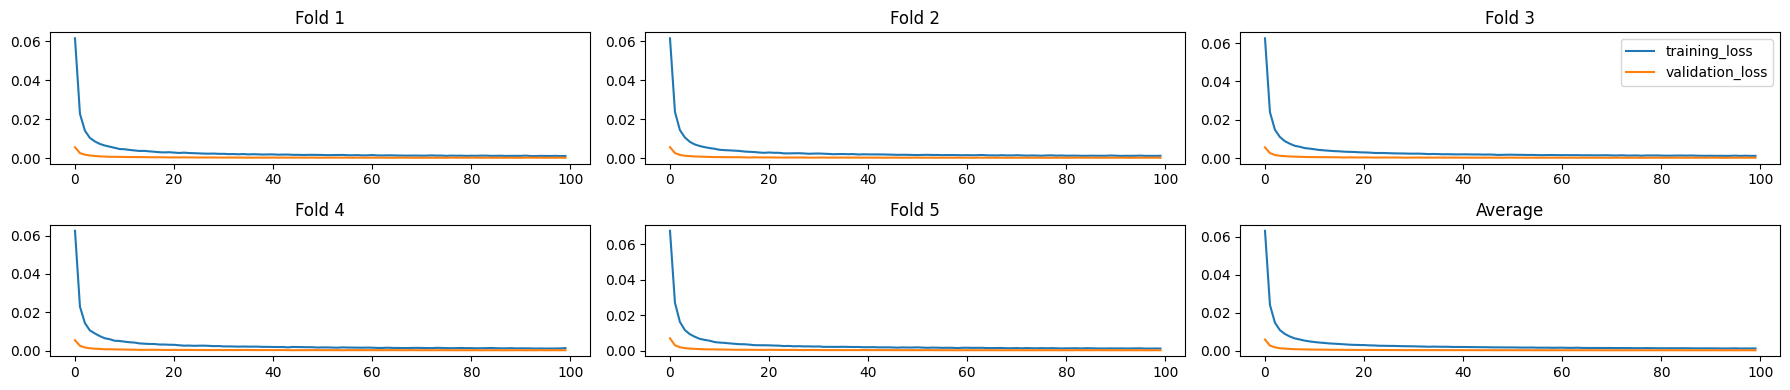

In [12]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(nrows=2, ncols=3, figsize=(18, 4))

ax1.plot(training_losses_list[0], label='training_loss')
ax1.plot(validation_losses_list[0], label='validation_loss')
ax1.set_title('Fold 1')

ax2.plot(training_losses_list[1], label='training_loss')
ax2.plot(validation_losses_list[1], label='validation_loss')
ax2.set_title('Fold 2')

ax3.plot(training_losses_list[2], label='training_loss')
ax3.plot(validation_losses_list[1], label='validation_loss')
ax3.set_title('Fold 3')

ax4.plot(training_losses_list[3], label='training_loss')
ax4.plot(validation_losses_list[3], label='validation_loss')
ax4.set_title('Fold 4')

ax5.plot(training_losses_list[4], label='training_loss')
ax5.plot(validation_losses_list[4], label='validation_loss')
ax5.set_title('Fold 5')

training_losses_average = [sum(x)/len(x) for x in zip(*training_losses_list)]
validation_losses_average = [sum(x)/len(x) for x in zip(*validation_losses_list)]
ax6.plot(training_losses_average, label='training_loss')
ax6.plot(validation_losses_average, label='validation_loss')
ax6.set_title('Average')

ax3.legend()
plt.tight_layout()

In [13]:
models = []
for fold in range(0, 5):
    model = Net().to(device)
    model.load_state_dict(torch.load(f'model_mnist_{fold+1}.pt', weights_only=False))
    model.eval()
    models.append(model)

testing_loader = DataLoader(testing_set, batch_size=len(testing_set), shuffle=False)

pred = np.zeros(280000).reshape(28000, 10)
with torch.no_grad():
    for model in models:
        for features in testing_loader:
            features = features.to(device)
            outputs = model(features)
            pred += 0.2 * outputs.cpu().numpy()

predictions = pd.DataFrame(np.argmax(pred, axis=1), columns=['Label'])

In [14]:
predictions.index += 1
predictions.index.name = 'ImageId'
predictions.to_csv('submission_v5.csv')